1.EDA (Exploratory Data Analysis)
Purpose:

Understand how solar power behaves before feeding to AI.

EDA Questions we answer
| Question              | Why                    |
| --------------------- | ---------------------- |
| Power vs Time of day  | Solar curve shape      |
| Weather vs Power      | Correlation discovery  |
| DC vs AC power        | Inverter efficiency    |
| Plant-wise comparison | Performance difference |
| Time patterns         | Seasonality            |


Typical EDA Plots

AC Power vs Hour of Day

TEMP vs AC Power scatter

IRRADIATION vs AC Power scatter

DC vs AC Power

Histogram of power output

2 — FEATURE ENGINEERING

INPUT FEATURES:
DC_POWER
AMBIENT_TEMPERATURE
MODULE_TEMPERATURE
IRRADIATION
hour
day
month
SOURCE_KEY (encoded)

TARGET:
AC_POWER

3-SCALING


 4 — SEQUENCE GENERATION
 Row data → SEQUENCES

Dataset shape: (68859, 15)


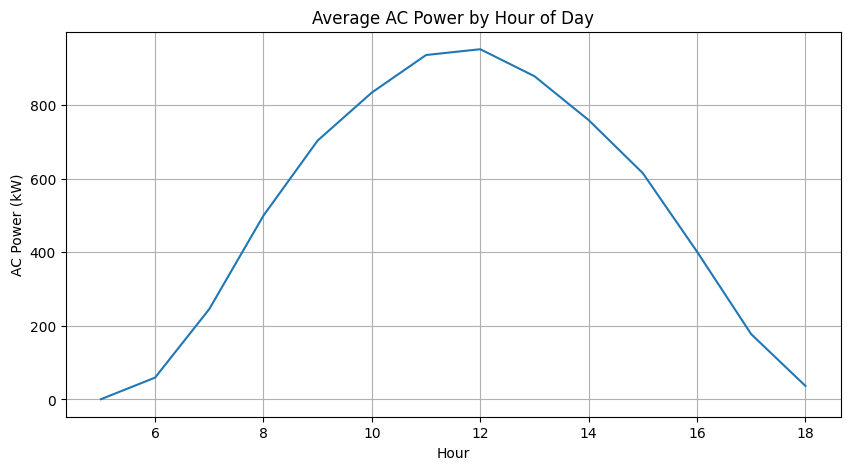

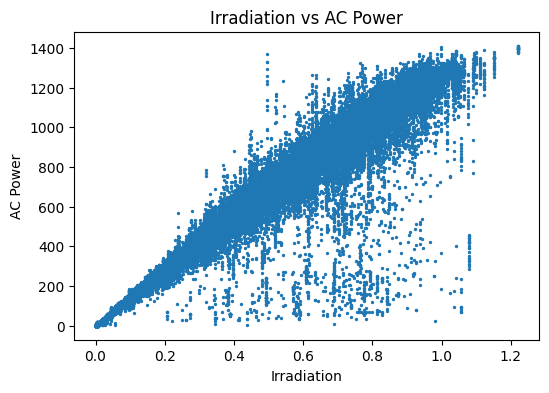

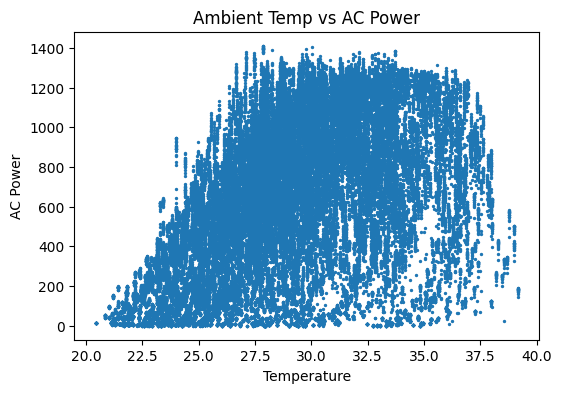

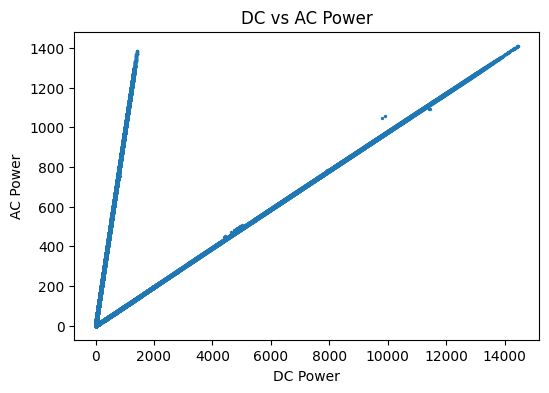

Features shape: (68859, 8)
Sequence X shape: (68835, 24, 8)
Sequence y shape: (68835,)

✅ Phase-2 complete
Files saved:
  - X_sequences.npy
  - y_targets.npy


In [4]:
# ==============================
#  PHASE 2 : EDA + FEATURE ENGINEERING
# ==============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ------------------------------
# LOAD MASTER DATASET
# ------------------------------

df = pd.read_csv("final_cleaned_dataset.csv")
df["DATE_TIME"] = pd.to_datetime(df["DATE_TIME"])

print("Dataset shape:", df.shape)
# Clean merge column mess

df.rename(columns={"SOURCE_KEY_x":"SOURCE_KEY"}, inplace=True)

df.drop(columns=["SOURCE_KEY_y","PLANT_ID_y"], inplace=True)

# ------------------------------
# E D A    S E C T I O N
# ------------------------------

# 1️⃣ AC Power by Hour
hour_means = df.groupby("hour")["AC_POWER"].mean()

plt.figure(figsize=(10,5))
plt.plot(hour_means)
plt.title("Average AC Power by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("AC Power (kW)")
plt.grid()
plt.show()

# 2️⃣ Relationships with weather

plt.figure(figsize=(6,4))
plt.scatter(df["IRRADIATION"], df["AC_POWER"], s=2)
plt.title("Irradiation vs AC Power")
plt.xlabel("Irradiation")
plt.ylabel("AC Power")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df["AMBIENT_TEMPERATURE"], df["AC_POWER"], s=2)
plt.title("Ambient Temp vs AC Power")
plt.xlabel("Temperature")
plt.ylabel("AC Power")
plt.show()

# 3️⃣ DC vs AC
plt.figure(figsize=(6,4))
plt.scatter(df["DC_POWER"], df["AC_POWER"], s=2)
plt.title("DC vs AC Power")
plt.xlabel("DC Power")
plt.ylabel("AC Power")
plt.show()

# ------------------------------
# FEATURE ENGINEERING
# ------------------------------

# Encode inverter ID
encoder = LabelEncoder()
df["SOURCE_KEY_ENC"] = encoder.fit_transform(df["SOURCE_KEY"])

# Features
feature_cols = [
    "DC_POWER",
    "AMBIENT_TEMPERATURE",
    "MODULE_TEMPERATURE",
    "IRRADIATION",
    "hour",
    "day",
    "month",
    "SOURCE_KEY_ENC"
]

X = df[feature_cols]
y = df["AC_POWER"]

print("Features shape:", X.shape)

# ------------------------------
# SCALING
# ------------------------------

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------
# CREATE LSTM SEQUENCES
# ------------------------------

SEQ_LEN = 24   # 6 hours history → predict next step

def create_sequences(X, y, seq_len):
    Xs = []
    ys = []

    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y.iloc[i+seq_len])

    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y, SEQ_LEN)

print("Sequence X shape:", X_seq.shape)
print("Sequence y shape:", y_seq.shape)

# ------------------------------
# SAVE OUTPUTS FOR PHASE-3
# ------------------------------

np.save("X_sequences.npy", X_seq)
np.save("y_targets.npy", y_seq)

print("\n Phase-2 complete")
print("Files saved:")
print("  - X_sequences.npy")
print("  - y_targets.npy")


In [5]:
print(df.columns)


Index(['DATE_TIME', 'PLANT_ID_x', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER',
       'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE',
       'MODULE_TEMPERATURE', 'IRRADIATION', 'hour', 'day', 'month',
       'SOURCE_KEY_ENC'],
      dtype='object')


phase 03

LSTM MODEL TRAINING

to:

Split training/testing data

Build LSTM neural network

Train model on solar data

Evaluate accuracy

Save trained model

X shape: (68835, 24, 8)
y shape: (68835,)
Training samples: 55068
Testing samples : 13767


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - loss: 419798.5938 - mae: 530.3841 - val_loss: 405746.2500 - val_mae: 517.4194
Epoch 2/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 393056.7500 - mae: 507.4171 - val_loss: 378978.0625 - val_mae: 495.2141
Epoch 3/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 368712.4688 - mae: 487.1832 - val_loss: 354106.7812 - val_mae: 475.2570
Epoch 4/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 343077.6250 - mae: 466.5637 - val_loss: 330433.0312 - val_mae: 453.5564
Epoch 5/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - loss: 318384.7188 - mae: 441.3080 - val_loss: 307400.9688 - val_mae: 429.4012
Epoch 6/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 300935.6875 - mae: 423.0282 - val_loss: 285937.6250 - val_mae: 409.0560
Epoch 7/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - loss: 278193.5938 - mae: 400.5671 - val_loss: 264814.5000 - val_mae: 387.2454
Epoch 8/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - loss: 


✅ Test MAE: 182.93893432617188

✅ Model Saved as: solar_forecasting_lstm.h5


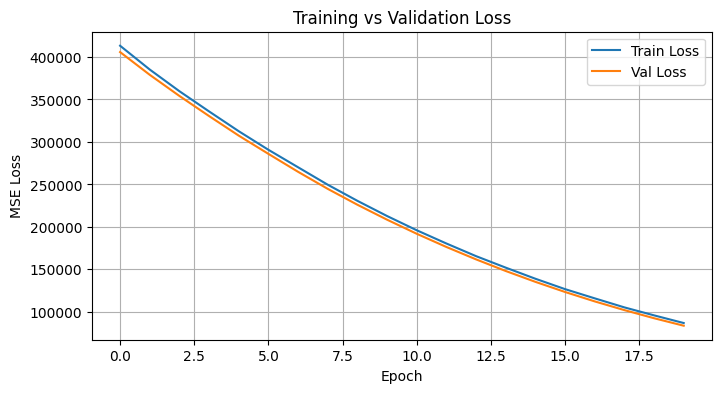

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


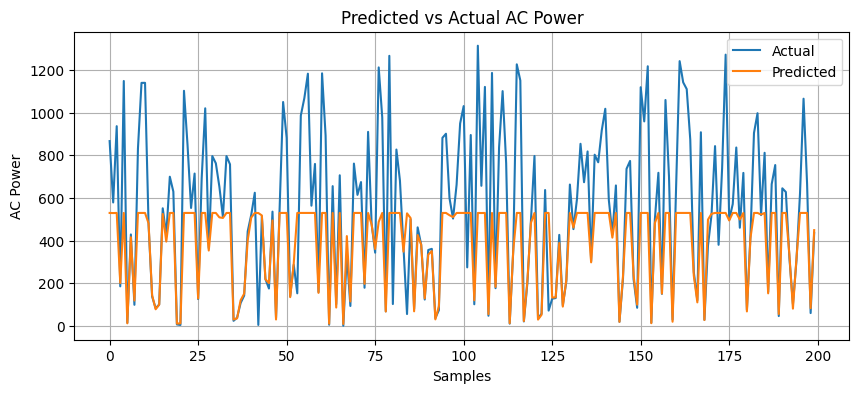


🎉 PHASE-3 COMPLETE — LSTM trained successfully


In [6]:
# ==============================
#       PHASE 3 : LSTM TRAINING
# ==============================

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ------------------------------
# LOAD PREPARED DATA
# ------------------------------

X = np.load("X_sequences.npy")
y = np.load("y_targets.npy")

print("X shape:", X.shape)
print("y shape:", y.shape)

# ------------------------------
# TRAIN TEST SPLIT
# ------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples :", X_test.shape[0])

# ------------------------------
# LSTM MODEL
# ------------------------------

model = Sequential()

model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(32))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mae"]
)

model.summary()

# ------------------------------
# MODEL TRAINING
# ------------------------------

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64
)

# ------------------------------
# MODEL EVALUATION
# ------------------------------

loss, mae = model.evaluate(X_test, y_test)
print("\n✅ Test MAE:", mae)

# ------------------------------
# SAVE TRAINED MODEL
# ------------------------------

model.save("solar_forecasting_lstm.h5")

print("\n✅ Model Saved as: solar_forecasting_lstm.h5")

# ------------------------------
# LOSS GRAPH
# ------------------------------

plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid()
plt.show()

# ------------------------------
# PREDICTION CHECK
# ------------------------------

preds = model.predict(X_test[:200])

plt.figure(figsize=(10,4))
plt.plot(y_test[:200], label="Actual")
plt.plot(preds, label="Predicted")
plt.title("Predicted vs Actual AC Power")
plt.xlabel("Samples")
plt.ylabel("AC Power")
plt.legend()
plt.grid()
plt.show()

print("\n🎉 PHASE-3 COMPLETE — LSTM trained successfully")


 we trained a deep learning LSTM model on the time-series sequences generated in Phase-2 by splitting the dataset into training and testing sets, fitting a stacked LSTM network to learn solar generation patterns, evaluating it using mean absolute error and loss curves, and saving the trained network (solar_forecasting_lstm.h5) for later inference and Streamlit app deployment.

In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np

preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("✅ RMSE :", rmse)


431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
✅ RMSE : 289.2401668244672


X shape: (68835, 24, 8)
y shape: (68835,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,617 (467.25 KB)

 Trainable params: 119,617 (467.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
1721/1721 ━━━━━━━━━━━━━━━━━━━━ 92s 51ms/step - loss: 398111.0000 - mae: 511.7582 - rmse: 630.8430 - val_loss: 332015.2812 - val_mae: 458.0305 - val_rmse: 576.2076
Epoch 2/60
1721/1721 ━━━━━━━━━━━━━━━━━━━━ 91s 53ms/step - loss: 305977.1875 - mae: 437.7936 - rmse: 553.0654 - val_loss: 259090.7031 - val_mae: 403.4015 - val_rmse: 509.0095
Epoch 3/60
1721/1721 ━━━━━━━━━━━━━━━━━━━━ 138s 50ms/step - loss: 240296.8906 - mae: 389.4577 - rmse: 490.1201 - val_loss: 206475.5938 - val_mae: 366.2625 - val_rmse: 454.3958
Epoch 4/60
1721/1721 ━━━━━━━━━━━━━━━━━━━━ 93s 54ms/step - loss: 192966.0938 - mae: 356.0385 - rmse: 439.2222 - val_loss: 151388.4219 - val_mae: 276.9663 - val_rmse: 389.0866
Epoch 5/60
1721/1721 ━━━━━━━━━━━━━━━━━━━━ 88s 51ms/step - loss: 135329.2969 - mae: 254.2881 - rmse: 367.7576 - val_loss: 105801.1016 - val_mae: 213.8560 - val_rmse: 325.2708
Epoch 6/60
1721/1721 ━━━━━━━━━━━━━━━━━━━━ 88s 51ms/step - loss: 94187.5469 - mae: 199.1962 - rmse: 306.8314 - val_loss: 74710.851


✅ FINAL RESULTS
MAE : 37.13106918334961
RMSE: 81.31735229492188

✅ Improved model saved as: solar_forecasting_lstm_optimized.h5


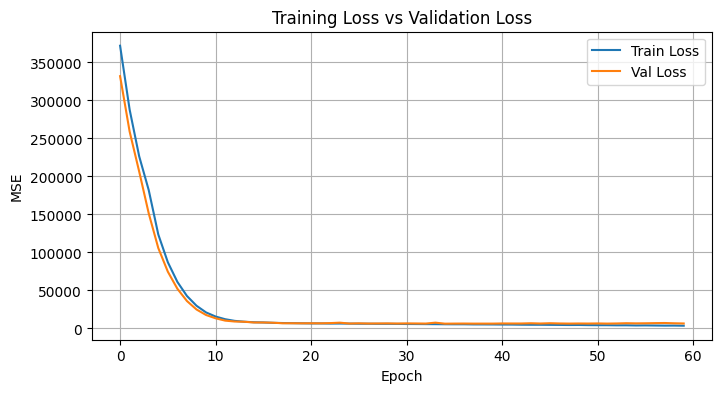

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


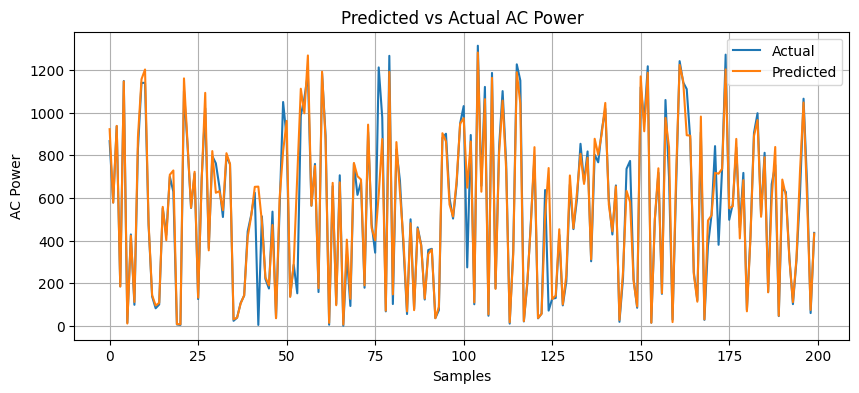


🎉 OPTIMIZED TRAINING COMPLETE


In [8]:
# =======================================
#    PHASE 3 – LSTM TRAINING (OPTIMIZED)
# =======================================

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# -----------------------------
# LOAD DATA
# -----------------------------

X = np.load("X_sequences.npy")
y = np.load("y_targets.npy")

print("X shape:", X.shape)
print("y shape:", y.shape)

# -----------------------------
# SPLIT INTO TRAIN & TEST
# -----------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# -----------------------------
# BUILD IMPROVED LSTM MODEL
# -----------------------------

model = Sequential()

model.add(
    LSTM(
        128,
        return_sequences=True,
        input_shape=(X.shape[1], X.shape[2])
    )
)

model.add(LSTM(64))

model.add(Dense(1))

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=[
        "mae",
        tf.keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

model.summary()

# -----------------------------
# TRAIN MODEL
# -----------------------------

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=60,
    batch_size=32
)

# -----------------------------
# EVALUATE
# -----------------------------

loss, mae, rmse = model.evaluate(X_test, y_test)

print("\n✅ FINAL RESULTS")
print("MAE :", mae)
print("RMSE:", rmse)

# -----------------------------
# SAVE MODEL
# -----------------------------

model.save("solar_forecasting_lstm_optimized.h5")

print("\n✅ Improved model saved as: solar_forecasting_lstm_optimized.h5")

# -----------------------------
# LOSS CURVES
# -----------------------------

plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Training Loss vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()

# -----------------------------
# PREDICTION CHECK
# -----------------------------

preds = model.predict(X_test[:200])

plt.figure(figsize=(10,4))
plt.plot(y_test[:200], label="Actual")
plt.plot(preds, label="Predicted")
plt.title("Predicted vs Actual AC Power")
plt.xlabel("Samples")
plt.ylabel("AC Power")
plt.legend()
plt.grid()
plt.show()

print("\n🎉 OPTIMIZED TRAINING COMPLETE")
